In [1]:
# Uncomment below command if 'transformers' library not installed already
#!pip install transformers

In [2]:
import re
import joblib
import random
import numpy as np
import transformers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import Conversation
from transformers.utils import logging
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
logging.set_verbosity_error()
chatbot = pipeline(task="conversational", model="facebook/blenderbot-400M-distill")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df = pd.read_csv("../content/Dataset.csv")
df

,Unnamed: 0,age,weight(kg),height(m),gender,BMI,BMR,activity_level,calories_to_maintain_weight,BMI_tags,Label
0,1,2,16.097862,0.932025,F,18.531612,958.584,1.2,1150.3008,8,13
1,2,4,14.619374,0.916687,F,17.397496,932.383,1.7,1585.0511,7,1
2,4,4,17.899918,0.997288,F,17.997414,977.578,1.9,1857.3982,7,4
3,6,3,13.532880,1.022786,F,12.936609,944.689,1.9,1794.9091,7,3
4,8,4,17.039484,1.053977,M,15.338909,799.229,1.9,1518.5351,7,0
...,...,...,...,...,...,...,...,...,...,...,...
10721,23986,72,95.444236,1.631113,F,35.874169,1510.154,1.3,1963.2002,9,26
10722,23988,85,97.976899,1.631409,F,36.812724,1473.418,1.7,2504.8106,9,30
10723,23994,50,97.761259,1.631864,F,36.711217,1635.925,1.7,2781.0725,9,31
10724,23997,57,96.829324,1.631290,F,36.386871,1593.981,1.3,2072.1753,9,27


## Data preparation

In [5]:
# Function to calculate body fat percentage for each row
def calculate_body_fat(row):
    weight = row['weight(kg)']
    height = row['height(m)']
    body_fat = (weight / (height**2)) * 10000 * 0.08 - 0.28
    return round(body_fat, 2)

# Function to calculate daily caloric needs for each row
def calculate_daily_calories(row):
    bmr = row['BMR']
    activity_level = row['activity_level']
    activity_multipliers = {
        'sedentary': 1.2,
        'lightly_active': 1.375,
        'moderately_active': 1.55,
        'very_active': 1.725,
        'extra_active': 1.9
    }
    activity_multiplier = activity_multipliers.get(activity_level, 1.2)
    return round(bmr * activity_multiplier, 2)

# Function to classify weight status based on BMI for each row
def classify_weight_status(row):
    bmi = row['BMI']
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Function to calculate lean body mass for each row
def calculate_lean_body_mass(row):
    weight = row['weight(kg)']
    body_fat_percentage = row['Body Fat Percentage']
    lean_body_mass = weight * (1 - (body_fat_percentage / 100))
    return round(lean_body_mass, 2)

In [6]:
# Calculate new features for each row
df['Body Fat Percentage'] = df.apply(calculate_body_fat, axis=1)
df['Daily Calories'] = df.apply(calculate_daily_calories, axis=1)
df['Weight Status'] = df.apply(classify_weight_status, axis=1)
df['Lean Body Mass'] = df.apply(calculate_lean_body_mass, axis=1)

df

,Unnamed: 0,age,weight(kg),height(m),gender,BMI,BMR,activity_level,calories_to_maintain_weight,BMI_tags,Label,Body Fat Percentage,Daily Calories,Weight Status,Lean Body Mass
0,1,2,16.097862,0.932025,F,18.531612,958.584,1.2,1150.3008,8,13,14825.01,1150.30,Normal weight,-2370.41
1,2,4,14.619374,0.916687,F,17.397496,932.383,1.7,1585.0511,7,1,13917.72,1118.86,Underweight,-2020.06
2,4,4,17.899918,0.997288,F,17.997414,977.578,1.9,1857.3982,7,4,14397.65,1173.09,Underweight,-2559.27
3,6,3,13.532880,1.022786,F,12.936609,944.689,1.9,1794.9091,7,3,10349.01,1133.63,Underweight,-1386.99
4,8,4,17.039484,1.053977,M,15.338909,799.229,1.9,1518.5351,7,0,12270.85,959.07,Underweight,-2073.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10721,23986,72,95.444236,1.631113,F,35.874169,1510.154,1.3,1963.2002,9,26,28699.06,1812.18,Obese,-27296.15
10722,23988,85,97.976899,1.631409,F,36.812724,1473.418,1.7,2504.8106,9,30,29449.90,1768.10,Obese,-28756.12
10723,23994,50,97.761259,1.631864,F,36.711217,1635.925,1.7,2781.0725,9,31,29368.69,1963.11,Obese,-28613.44
10724,23997,57,96.829324,1.631290,F,36.386871,1593.981,1.3,2072.1753,9,27,29109.22,1912.78,Obese,-28089.43


## Dataset exploration

In [7]:
print("Number of Nan values in dataframe are:", len(df) - len(df.isnull()))

Number of Nan values in dataframe are: 0


In [8]:
df.describe()

,Unnamed: 0,age,weight(kg),height(m),BMI,BMR,activity_level,calories_to_maintain_weight,BMI_tags,Label,Body Fat Percentage,Daily Calories,Lean Body Mass
count,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000,10726.000000
mean,11664.753123,26.778575,61.647728,1.540276,24.788317,1442.049923,1.487451,2118.574075,8.253496,19.332650,19830.373418,1730.459923,-13448.894005
std,6814.683196,18.201675,24.254566,0.186042,6.954637,250.686166,0.239625,388.425427,0.754767,9.746498,5563.709772,300.823434,8303.526167
min,1.000000,2.000000,12.005536,0.856328,10.342285,667.941000,1.200000,953.540900,7.000000,0.000000,8273.550000,801.530000,-29251.110000
25%,5959.750000,13.000000,45.538375,1.564845,19.557137,1320.322500,1.300000,1815.879700,8.000000,16.000000,15645.430000,1584.382500,-20845.685000
50%,10695.500000,23.000000,61.323460,1.631282,23.056039,1493.165000,1.500000,2104.599800,8.000000,20.000000,18444.555000,1791.800000,-11227.785000
75%,17455.250000,36.000000,83.484585,1.632234,31.334294,1602.488000,1.700000,2405.301750,9.000000,28.000000,25067.155000,1922.982500,-7139.000000
max,23998.000000,90.000000,98.799820,1.633223,37.142927,1914.374000,1.900000,2949.075500,9.000000,31.000000,29714.060000,2297.250000,-983.500000


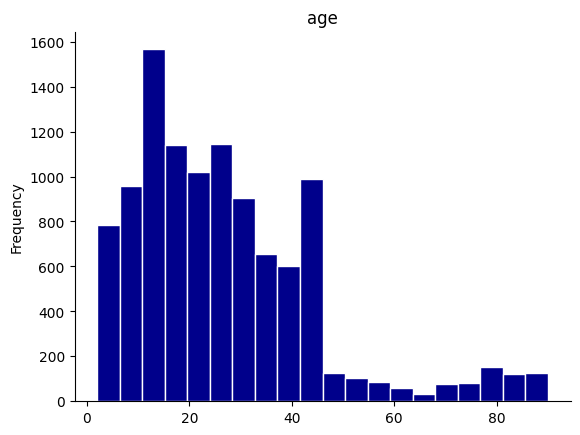

In [9]:
df['age'].plot(kind='hist', bins=20, title='age', color='darkblue', edgecolor='white')
plt.gca().spines[['top', 'right',]].set_visible(False)

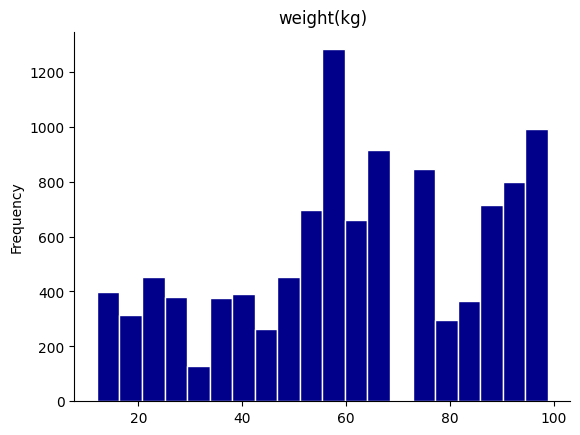

In [10]:
df['weight(kg)'].plot(kind='hist', bins=20, title='weight(kg)', color='darkblue', edgecolor='white')
plt.gca().spines[['top', 'right',]].set_visible(False)

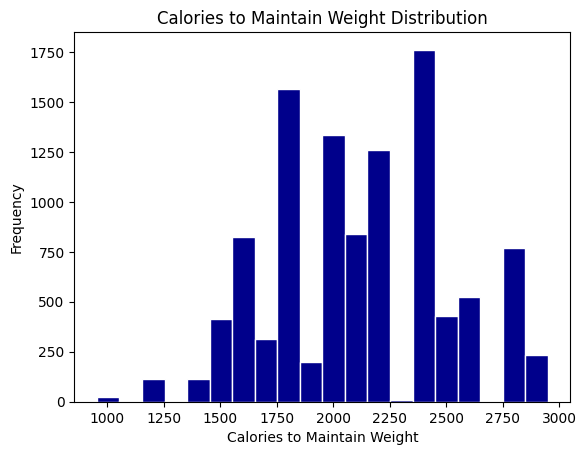

In [11]:
# Plotting Calories to Maintain Weight Distribution
plt.figure()
plt.hist(df['calories_to_maintain_weight'], bins=20, color='darkblue', edgecolor='white')
plt.title('Calories to Maintain Weight Distribution')
plt.xlabel('Calories to Maintain Weight')
plt.ylabel('Frequency')
plt.show()

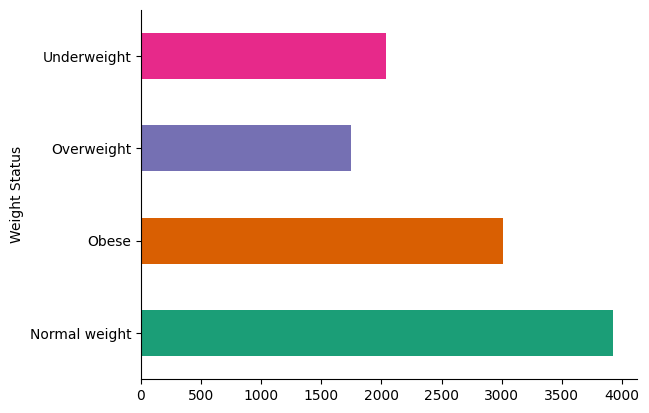

In [12]:
df.groupby('Weight Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

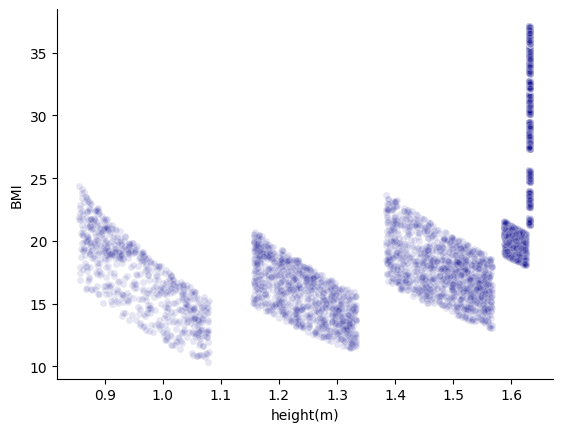

In [13]:
df.plot(kind='scatter', x='height(m)', y='BMI', s=24, alpha=0.1, color='darkblue', edgecolor='white')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-14-611aad6b3067>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='BMI', y='gender', inner='box', palette='Dark2')


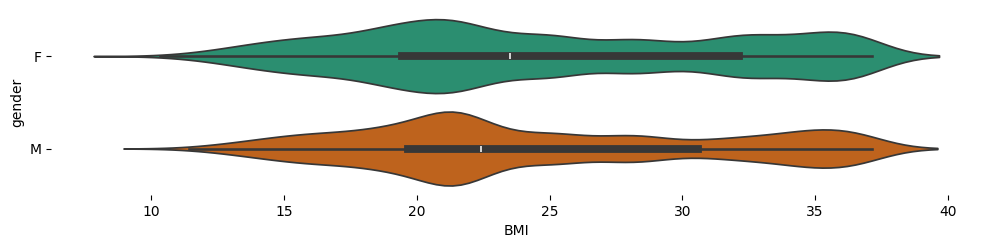

In [14]:
figsize = (12, 1.2 * len(df['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='BMI', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-15-cf284d02e83b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='age', y='Weight Status', inner='box', palette='Dark2')


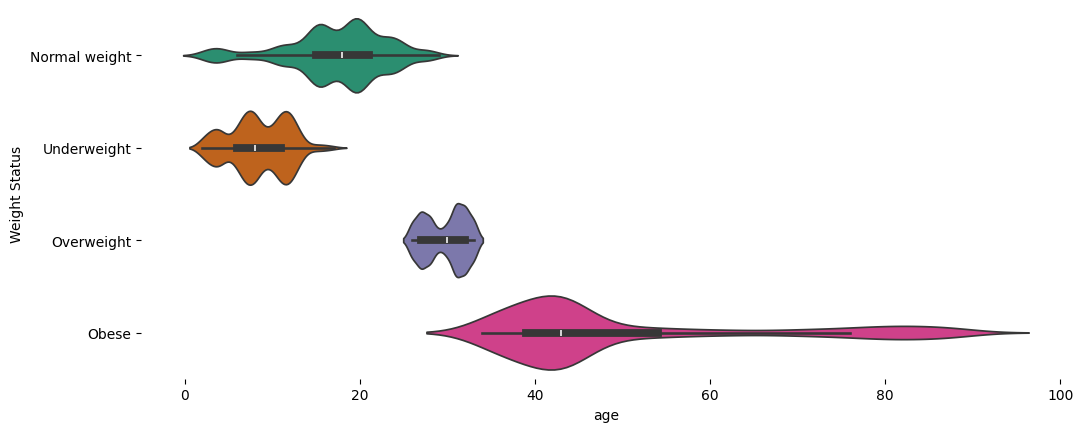

In [15]:
figsize = (12, 1.2 * len(df['Weight Status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='Weight Status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

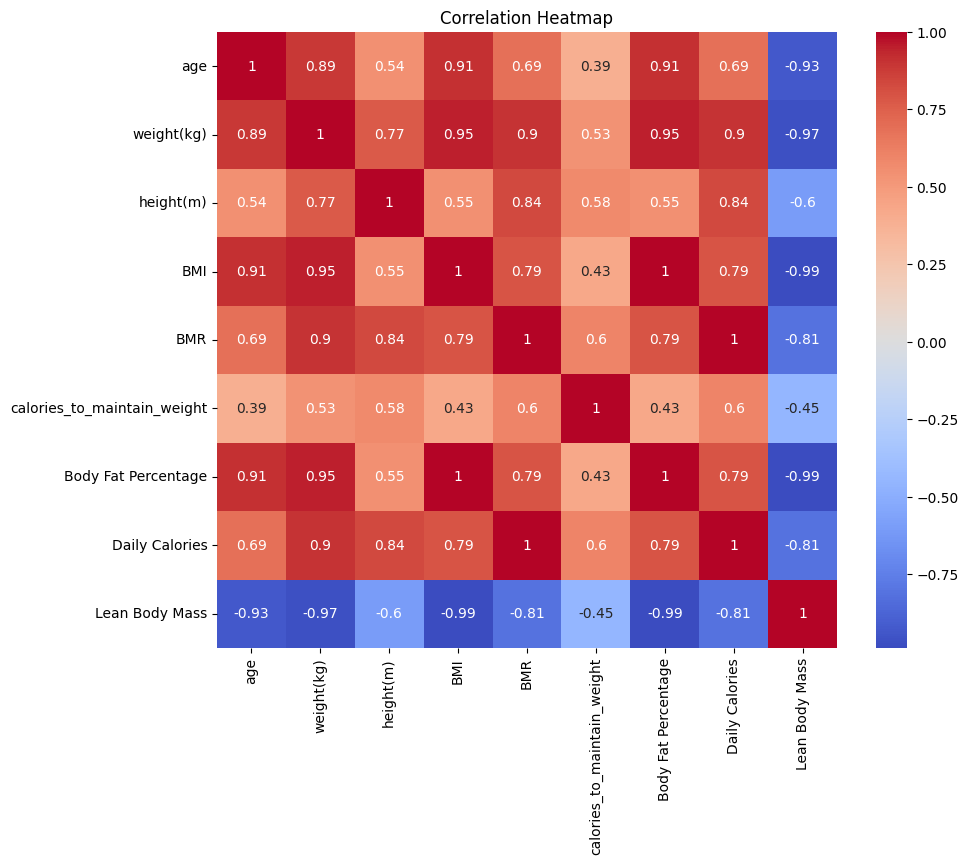

In [16]:
numerical_features = ['age', 'weight(kg)', 'height(m)', 'BMI', 'BMR', 'calories_to_maintain_weight', 'Body Fat Percentage', 'Daily Calories', 'Lean Body Mass']

# Correlation heatmap for numerical features
corr = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [17]:
df = df.drop(columns=['Unnamed: 0', 'Label'])

## Creating clusters and getting prediction of users weight status

In [18]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def assign_points_to_clusters(clusters, data):
    labels = []
    for point in data:
        distances = [euclidean_distance(point, cluster) for cluster in clusters]
        min_distance = min(distances)
        label = distances.index(min_distance)
        labels.append(label)
    return labels

def compute_clusters(data, labels, n_clusters):
    new_clusters = []
    for i in range(n_clusters):
        points = [point for point, label in zip(data, labels) if label == i]
        new_cluster = [sum(col) / len(col) for col in zip(*points)]
        new_clusters.append(new_cluster)
    return new_clusters

def kmeans(data, n_clusters, max_iters=10000):
    clusters = random.sample(data, n_clusters)
    for _ in range(max_iters):
        labels = assign_points_to_clusters(clusters, data)
        new_clusters = compute_clusters(data, labels, n_clusters)
        if new_clusters == clusters:
            break
        clusters = new_clusters
    return labels, clusters

# Create instances of LabelEncoder and StandardScaler
le = LabelEncoder()
scaler = StandardScaler()

# Preprocess the data
df['gender'] = le.fit_transform(df['gender'])

# Separate the features and target
X = df.drop(columns='Weight Status')
y = df['Weight Status']

# Standardize the features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train the model
n_clusters = len(y.unique())  # Number of clusters equals the number of unique classes
labels, clusters = kmeans(X.values.tolist(), n_clusters)

# Map cluster labels to the majority class within each cluster
cluster_majority_class = {}
for cluster_label in set(labels):
    indices = [i for i, label in enumerate(labels) if label == cluster_label]
    cluster_classes = y.iloc[indices]
    majority_class = cluster_classes.mode()[0]  # Most frequent class in the cluster
    cluster_majority_class[cluster_label] = majority_class

predicted_labels = [cluster_majority_class[label] for label in labels]

# Evaluate the model
accuracy = accuracy_score(y, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

def predict_weight_status(user_data, clusters, cluster_majority_class):
    # Create new instances of LabelEncoder and StandardScaler
    le = LabelEncoder()
    scaler = StandardScaler()

    # Convert categorical data to numerical
    user_data[3] = le.fit_transform([user_data[3]])[0]

    # Standardize the user data
    label = assign_points_to_clusters(clusters, user_data)

    # Assign the user data point to the nearest cluster
    labels = assign_points_to_clusters(clusters, [user_data])

    # Return the majority class of the assigned cluster
    return cluster_majority_class[labels[0]]

Accuracy: 80.92%


In [19]:
user_data = [50, 97.761259, 1.631864, 'F', 36.711217, 1635.925, 2781.0725, 9, 31, 29368.69, 1963.11, -28613.44]

# Predict the weight status
weight_status = predict_weight_status(user_data, clusters, cluster_majority_class)
print(f'The predicted weight status is: {weight_status}')

The predicted weight status is: Obese


## Reading 'Food and Calories' dataset to plan the diet

In [20]:
df2 = pd.read_csv("../content/Food and Calories - Sheet1.csv")
df2

,Food,Serving,Calories
0,Artichoke,1 artichoke (128 g),60 cal
1,Arugula,1 leaf (2 g),1 cal
2,Asparagus,1 spear (12 g),2 cal
3,Aubergine,1 aubergine (458 g),115 cal
4,Beetroot,1 beet (82 g),35 cal
...,...,...,...
557,Wendy’s Jr. Cheeseburger,1 burger (129 g),290 cal
558,Wendy’s Son of Baconator,1 burger (218 g),700 cal
559,Whopper,1 burger (291 g),672 cal
560,Zinger,1 sandwich (202 g),517 cal


### Diet planning and use of LLM's to generate text

In [21]:
def extract_numeric_value(s):
    """Function to extract numeric value from a string"""
    match = re.search(r'\d+', str(s))
    if match:
        return int(match.group())
    else:
        return 0


def diet_plan():
    normal_rows = df[df['Weight Status'] == 'Normal weight']
    average_daily_calories = normal_rows['Daily Calories'].mean()


    if weight_status == 'Normal':
        weight_maintain_cal = average_daily_calories
        df2_shuffled = df2.sample(frac=1)

        selected_foods = []
        total_calories = 0

        for index, row in df2_shuffled.iterrows():
            food = row['Food']
            calories = extract_numeric_value(row['Calories'])  # Extract numeric value from calories

            # Calculate serving size dynamically
            remaining_calories = weight_maintain_cal - total_calories
            serving = min(remaining_calories // calories, 1)  # Ensure serving is at least 1
            serving = max(1, serving)  # Ensure serving is not less than 1

            total_calories += calories * serving

            if total_calories <= weight_maintain_cal:
                selected_foods.append((food, serving, calories))
            else:
                break  # Stop iteration if total calories exceed weight_maintain_cal

        # Print the selected foods
        for food, serving, calories in selected_foods:
            print(f"Food: {food}, Serving: {serving}, Calories: {calories}")
            user_message = f"""Why is it medically beneficial to eat {food} in your diet?"""
            conversation = Conversation(user_message)
            conversation = chatbot(conversation)
            print(conversation)

            # Prompt with placeholder for similar options
            prompt = f"We recommend having {serving} servings of {food}. You might also consider [similar_{conversation} options]."


    elif weight_status == 'Obese':
        obese_rows = df[df['Weight Status'] == 'Obese']
        average_daily_cal = obese_rows['Daily Calories'].mean()
        weight_maintain_cal = average_daily_cal - average_daily_calories
        weight_maintain_cal = average_daily_calories - weight_maintain_cal
        df2_shuffled = df2.sample(frac=1)

        selected_foods = []
        total_calories = 0

        for index, row in df2_shuffled.iterrows():
            food = row['Food']
            calories = extract_numeric_value(row['Calories'])  # Extract numeric value from calories

            # Calculate serving size dynamically
            remaining_calories = weight_maintain_cal - total_calories
            serving = min(remaining_calories // calories, 1)  # Ensure serving is at least 1
            serving = max(1, serving)  # Ensure serving is not less than 1

            total_calories += calories * serving

            if total_calories <= weight_maintain_cal:
                selected_foods.append((food, serving, calories))
            else:
                break  # Stop iteration if total calories exceed weight_maintain_cal

        # Print the selected foods
        for food, serving, calories in selected_foods:
            print(f"Food: {food}, Serving: {serving}, Calories: {calories}")
            user_message = f"""Why is it medically beneficial to eat {food} in your diet?"""
            conversation = Conversation(user_message)
            conversation = chatbot(conversation)
            print(conversation)

            # Prompt with placeholder for similar options
            prompt = f"We recommend having {serving} servings of {food}. You might also consider [similar_{conversation} options]."


    elif weight_status == 'Overweight':
        overwgt_rows = df[df['Weight Status'] == 'Overweight']
        average_daily_cal = overwgt_rows['Daily Calories'].mean()
        weight_maintain_cal = average_daily_cal - average_daily_calories
        weight_maintain_cal = average_daily_calories - weight_maintain_cal
        df2_shuffled = df2.sample(frac=1)

        selected_foods = []
        total_calories = 0

        for index, row in df2_shuffled.iterrows():
            food = row['Food']
            calories = extract_numeric_value(row['Calories'])  # Extract numeric value from calories

            # Calculate serving size dynamically
            remaining_calories = weight_maintain_cal - total_calories
            serving = min(remaining_calories // calories, 1)  # Ensure serving is at least 1
            serving = max(1, serving)  # Ensure serving is not less than 1

            total_calories += calories * serving

            if total_calories <= weight_maintain_cal:
                selected_foods.append((food, serving, calories))
            else:
                break  # Stop iteration if total calories exceed weight_maintain_cal

        # Print the selected foods
        for food, serving, calories in selected_foods:
            print(f"Food: {food}, Serving: {serving}, Calories: {calories}")
            user_message = f"""Why is it medically beneficial to eat {food} in your diet?"""
            conversation = Conversation(user_message)
            conversation = chatbot(conversation)
            print(conversation)

            # Prompt with placeholder for similar options
            prompt = f"We recommend having {serving} servings of {food}. You might also consider [similar_{conversation} options]."


    elif weight_status == 'Underweight':
        underwgt_rows = df[df['Weight Status'] == 'Underweight']
        average_daily_cal = underwgt_rows['Daily Calories'].mean()
        weight_maintain_cal = average_daily_cal - average_daily_calories
        weight_maintain_cal = average_daily_calories + weight_maintain_cal
        df2_shuffled = df2.sample(frac=1)

        selected_foods = []
        total_calories = 0

        for index, row in df2_shuffled.iterrows():
            food = row['Food']
            calories = extract_numeric_value(row['Calories'])  # Extract numeric value from calories

            # Calculate serving size dynamically
            remaining_calories = weight_maintain_cal - total_calories
            serving = min(remaining_calories // calories, 1)  # Ensure serving is at least 1
            serving = max(1, serving)  # Ensure serving is not less than 1

            total_calories += calories * serving

            if total_calories <= weight_maintain_cal:
                selected_foods.append((food, serving, calories))
            else:
                break  # Stop iteration if total calories exceed weight_maintain_cal

        # Print the selected foods
        for food, serving, calories in selected_foods:
            print(f"Food: {food}, Serving: {serving}, Calories: {calories}")
            user_message = f"""Why is it medically beneficial to eat {food} in your diet?"""
            conversation = Conversation(user_message)
            conversation = chatbot(conversation)
            print(conversation)

            # Prompt with placeholder for similar options
            prompt = f"We recommend having {serving} servings of {food}. You might also consider [similar_{conversation} options]."



diet_plan()

Food: Snickers Ice Cream, Serving: 1, Calories: 180
Conversation id: d3dd46c4-93d1-48bd-8503-836e3edbdb7e
user: Why is it medically beneficial to eat Snickers Ice Cream in your diet?
assistant:  I think it is because it is a sweetened frozen dessert that is sweetened with sugar instead of high fructose corn syrup.

Food: Ham and Cheese Sandwich, Serving: 1, Calories: 352
Conversation id: 57f528d3-e603-4f47-aa3c-409f8e7c887e
user: Why is it medically beneficial to eat Ham and Cheese Sandwich in your diet?
assistant:  I think it is because it is low in carbohydrates and high in fat.

Food: Wholegrain Oat, Serving: 1, Calories: 300
Conversation id: 2522853c-d41b-4cd7-a0e1-48a9186e9974
user: Why is it medically beneficial to eat Wholegrain Oat in your diet?
assistant:  It is a high-fat, moderate-protein, low-carbohydrate diet.

Food: Sausage Roll, Serving: 1, Calories: 361
Conversation id: d8aaab20-08db-4627-8858-b4c43cd4b93b
user: Why is it medically beneficial to eat Sausage Roll in your